# MHKiT Loads Module
The following example will help familiarize you with some of the functions in the [MHKiT loads module](https://mhkit-software.github.io/MHKiT/mhkit-python/api.loads.html) that you can use to assist you in your loads analysis. 

Start by importing the necessary python packages and MHKiT module.

In [1]:
import pandas as pd 
import numpy as np 
from mhkit import utils
from mhkit import loads 
import matplotlib.pyplot as plt 

## Import Loads Data 

This example data comes from a land based wind turbine, since there is limited availablality of loads data for MHK devices. The example uses a subset of data from a database of 331 files, each containing 10 minutes of data sampled at 50Hz. 

As a start, lets look at the data for one of these files to figure out what formatting we need to apply. We utilize pandas to read in the csv and peek into what the data looks like. 

In [2]:
loads_data_file = './data/loads/data_loads_example.csv'

# Import csv data file
raw_loads_data = pd.read_csv(loads_data_file)
raw_loads_data.head()

,Timestamp,Time,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
0,42795.061586,0.00,3.226754,1.0,157.302829,157.279582,-41.380694,-234.487436,-6.207381,-70.130726,-936.247028,-12.605151,-330.410779,1024.816867,470.774738,-165.541786,33.427748,-59.452360,-5.279680,0.023247
1,42795.061586,0.02,3.221099,1.0,157.302829,157.279582,-38.614459,-233.715870,-8.886200,-66.916338,-942.675906,-24.350452,-315.445562,873.214212,469.244736,-163.588005,32.697822,-62.300637,-5.671178,0.023247
2,42795.061586,0.04,3.223492,1.0,157.302829,157.279582,-39.717967,-234.341966,-7.970862,-67.860011,-922.971018,-22.485796,-292.252115,876.299461,468.736474,-166.018111,35.495810,-61.733604,-5.551847,0.023247
3,42795.061586,0.06,3.223274,1.0,157.302829,157.279582,-41.415143,-235.645598,-10.451794,-72.371951,-939.515265,-33.030892,-274.812769,763.833828,467.373452,-164.645639,37.952455,-64.390050,-4.626557,0.023247
4,42795.061587,0.08,3.223927,1.0,157.302829,157.279582,-38.614459,-234.755991,-8.648988,-76.530014,-924.771486,-29.228398,-310.213400,704.537757,466.318754,-161.233863,37.430668,-65.974766,-4.708621,0.023247


### Format Loads Data with datetime index

To use MHKiT it is important to index your DataFrame by datetime. The example loads data has two references to time, but neither are in the right format. The `'Timestamp'` column is what will give us the datetime index that we need, but we first need to convert it from microsoft excel format to pd.Datetime. 

In [3]:
# Use the datetime conversion from the utils module
datetime = utils.excel_to_datetime(raw_loads_data['Timestamp'])

# Replace the 'Timestamp' column with our newly formatted datetime
raw_loads_data['Timestamp'] = datetime 

# Set this as our index for our DataFrame
loads_data = raw_loads_data.set_index('Timestamp')

# Remove the 'time' column since it will not be used
loads_data.drop(columns='Time',inplace=True)
loads_data.head()

,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
Timestamp,,,,,,,,,,,,,,,,,,
2017-03-01 01:28:40.999987200,3.226754,1.0,157.302829,157.279582,-41.380694,-234.487436,-6.207381,-70.130726,-936.247028,-12.605151,-330.410779,1024.816867,470.774738,-165.541786,33.427748,-59.452360,-5.279680,0.023247
2017-03-01 01:28:41.020032000,3.221099,1.0,157.302829,157.279582,-38.614459,-233.715870,-8.886200,-66.916338,-942.675906,-24.350452,-315.445562,873.214212,469.244736,-163.588005,32.697822,-62.300637,-5.671178,0.023247
2017-03-01 01:28:41.039990400,3.223492,1.0,157.302829,157.279582,-39.717967,-234.341966,-7.970862,-67.860011,-922.971018,-22.485796,-292.252115,876.299461,468.736474,-166.018111,35.495810,-61.733604,-5.551847,0.023247
2017-03-01 01:28:41.060035200,3.223274,1.0,157.302829,157.279582,-41.415143,-235.645598,-10.451794,-72.371951,-939.515265,-33.030892,-274.812769,763.833828,467.373452,-164.645639,37.952455,-64.390050,-4.626557,0.023247
2017-03-01 01:28:41.079993600,3.223927,1.0,157.302829,157.279582,-38.614459,-234.755991,-8.648988,-76.530014,-924.771486,-29.228398,-310.213400,704.537757,466.318754,-161.233863,37.430668,-65.974766,-4.708621,0.023247


## Loads Analysis
Now that we have our loads data in the correct format for MHKiT, we do some analysis.

### Damage Equivalent Loads
Lets say that we wanted to investigate fatigue. We can do this by calculating short-term damage equivalent loads (DELs). In this instance, we calculate the DELs on the tower base moment `'TB_ForeAft'`, and on blade 1 root flap moment `'BL1_FlapMom'`. Our tower is steel while our blade is composite so they will have different material slopes. We will run the function `damage_equivalent_load` on each data signal. 

We call our function and apply the default inputs of using at least 100 bins for the load ranges and we let data_length=600 seconds so that we get an equivalent 1Hz DEL for our 10 minute file. 

In [4]:
# Calculate the damage equivalent load for blade 1 root momement and tower base moment
DEL_tower = loads.general.damage_equivalent_load(loads_data['TB_ForeAft'],4,
                                         bin_num=100,data_length=600)
DEL_blade = loads.general.damage_equivalent_load(loads_data['BL1_FlapMom'],10,
                                         bin_num=100,data_length=600)
print('DEL TB_ForeAft: '+ str(DEL_tower))
print('DEL BL1_FlapMom: '+ str(DEL_blade))

DEL TB_ForeAft: 3912.6390862773
DEL BL1_FlapMom: 1435.8222478714554


### Calculate Statistics

Another important part of loads analysis is looking at statistics. Here, we use another function to help us calculate the mean, max, min, and std for this 10 minute file. Per standards, a valid statistical window has to be consecutive in time with the correct number of datapoints. If this 10 minute file did meet this criteria, then no stats would be generated and a warning message would appear. 

NOTE: Sometimes individual files may contain enough data for multiple statistical windows. This function can still handle this scenario as long as the correct inputs are specified.  

In [5]:
# Calculate the means, maxs, mins, and stdevs for all data signals in the loads data file
means,maxs,mins,stdevs = utils.get_statistics(loads_data,50,period=600)

# Display the results, indexed by the first timestamp of the corresponding statistical window
means

,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
2017-03-01 01:28:41,7.773325,1.0,178.612256,178.602595,127.244191,-252.23813,3.50322,7.032573,-846.663367,271.446574,3785.034515,7.199176,-494.858287,266.790368,-452.652744,21.259999,234.578289,0.009661


At this point, it would be nice to start visualizing some of this data. In order to do this, we need to calculate the stats and DELs for all the files in our database. In this case, it would be done through a loop that imports each file and applies all the functions we just saw. At the end of the loop, we store the result by appending to a list (this is computationally more efficient than concatenating dataframes). Finally, we can convert our lists to dataframes so that its easier to play with the data. To speed things up, this was already done so we just need to import the resulting dataframes.  

As a reference, an example code block is shown of how to create a loop that calculates all the means for each file which are then stored into a dataframe. 

```python
# pre-allocate lists for storage
means = []
time = []

# start loop
for f in os.listdir(pathOut):
    if f.endswith('.csv'):
        # import csv file
        raw_loads_data = pd.read_csv(pathOut+'/'+f)
        # replace the timestamp column with formatted datetime
        datetime = utils.excel_to_datetime(raw_loads_data['Timestamp']) 
        raw_loads_data['Timestamp'] = datetime 
        # set this as our index for our dataframe
        loads_data = raw_loads_data.set_index('Timestamp')
        # remove the "time" column as its unnecessary 
        loads_data.drop(columns='Time',inplace=True)
        # get stats
        fmean, fmax, fmin, fstd = utils.get_statistics(loads_data,freq=50,period=600)
        means.append(fmean.values.tolist())
        time.append(fmean.index.values)

# convert lists into a dataframe
loads_means = pd.DataFrame(np.squeeze(means),columns=loads_data.columns.values,index=time)
```

In [6]:
# Load DataFrames containing load statistics
means = pd.read_csv('./data/loads/data_loads_means.csv')
maxs = pd.read_csv('./data/loads/data_loads_maxs.csv')
mins = pd.read_csv('./data/loads/data_loads_mins.csv')
std = pd.read_csv('./data/loads/data_loads_std.csv')

means.head()

,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
0,7.773325,1.0,178.612256,178.602595,127.244191,-252.238130,3.503220,7.032573,-846.663367,271.446574,3785.034515,7.199176,-494.858288,266.790368,-452.652743,21.259999,234.578289,0.009661
1,4.294855,1.0,171.095503,171.104399,6.705063,-242.954279,8.781801,13.574055,-1005.504041,210.432881,504.631955,-63.459058,-123.664013,179.906995,-95.184346,-44.686204,32.156167,-0.008896
2,5.210606,1.0,168.688106,168.680758,51.782698,-224.455118,15.310279,-53.986054,-926.132830,138.439249,1992.287971,-42.414665,-314.992337,228.895991,-270.323145,-5.000843,87.337237,0.007348
3,14.210652,1.0,182.695493,182.688322,386.484523,-218.151791,13.457946,-39.223265,-568.024026,515.128540,7075.518787,649.320139,-689.885628,301.399047,-718.343755,77.781426,692.061262,0.007171
4,10.558234,1.0,182.443087,182.426475,561.122866,-228.167278,-30.095950,-51.686133,-347.327549,621.974202,10992.154570,598.674976,-1089.599789,374.679600,-1151.084828,138.214755,997.975514,0.016613


### Plot Statistics

Now that we have the load statistics, lets display the data as scatter plot. Using the `plot_statistics` function, we can quickly create a standard scatter plot showing how load variables trend with wind speed. Using this we can quickly identify expected trends and track down outliers. 

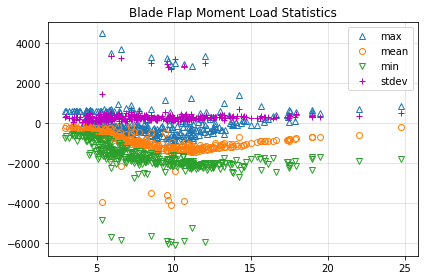

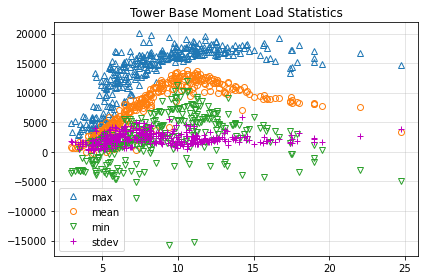

In [7]:
loads.graphics.plot_statistics(means['uWind_80m'],
                      means['BL1_FlapMom'],
                      maxs['BL1_FlapMom'],
                      mins['BL1_FlapMom'],
                      y_stdev=std['BL1_FlapMom'],
                      xlabel='Wind Speed [m/s]',
                      ylabel='Blade Flap Moment [kNm]',
                      title = 'Blade Flap Moment Load Statistics')

loads.graphics.plot_statistics(means['uWind_80m'],
                      means['TB_ForeAft'],
                      maxs['TB_ForeAft'],
                      mins['TB_ForeAft'],
                      y_stdev=std['TB_ForeAft'],
                      xlabel='Wind Speed [m/s]',
                      ylabel='Tower Base Moment [kNm]',
                      title = 'Tower Base Moment Load Statistics')

Another common step is to bin the statistical data. This can easily be done with the bin_stats function from the loads module shown below. A warning message will show if there are any bins that were not filled. 

In [8]:
# Create array containing wind speeds to use as bin edges
bin_edges = np.arange(3,26,1)
bin_against = means['uWind_80m']

# Apply function for means, maxs, and mins 
[bin_means, bin_means_std] = loads.general.bin_statistics(means,bin_against,bin_edges)
[bin_maxs, bin_maxs_std] = loads.general.bin_statistics(maxs,bin_against,bin_edges)
[bin_mins, bin_mins_std] = loads.general.bin_statistics(mins,bin_against,bin_edges)

bin_means

,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
0,3.582788,1.000000,179.116583,179.215605,29.890756,-252.235192,-2.931479,-26.271654,-932.953738,126.807011,994.638671,-102.050137,-206.591291,129.390923,-238.085263,-14.874877,21.370858,-0.099022
1,4.498995,1.000000,178.968041,178.963826,77.559257,-248.081262,-3.389182,-51.890684,-856.012087,154.470046,2235.672810,55.864708,-327.707803,162.318746,-354.474414,-7.655706,76.033527,0.004216
2,5.525786,0.980392,180.016225,179.996997,171.459516,-230.697510,-2.588070,-50.333653,-761.047719,213.700239,3822.643018,137.424215,-495.457116,191.503291,-599.658658,1436.266991,167.928433,0.019228
3,6.520641,0.970588,180.835469,180.788600,219.138550,-237.979417,-5.688640,-42.827109,-647.310249,302.591017,6122.425105,192.772384,-708.321569,237.072176,-777.545681,599.754365,317.629187,0.046869
4,7.534458,1.000000,181.373937,181.474371,285.072650,-240.838000,-8.602511,-56.222891,-571.093365,376.755167,7551.899048,296.723677,-861.049383,252.077699,-874.336546,88.957621,454.388684,-0.100434
5,8.483451,0.966667,180.006753,180.002341,405.504595,-233.796744,-7.596248,-32.233513,-430.681550,502.070942,9938.523640,335.667789,-1073.556266,313.335072,-1167.966930,1302.506123,679.886822,0.004413
6,9.635533,0.880000,178.894596,178.885289,581.709245,-218.693601,-8.801577,-72.657764,-330.525678,668.243228,11477.966048,588.384954,-1209.842191,342.343342,-1526.574097,4686.436750,942.635185,0.009307
7,10.552790,0.892857,179.473587,179.487138,653.097969,-224.998487,-5.756869,-62.714160,-283.620699,750.186980,12002.102796,740.834502,-1234.723513,354.710593,-1380.119025,2065.459821,1101.930764,-0.013551
8,11.431282,0.814807,179.157452,179.173400,738.418861,-209.685631,-1.320960,-22.419344,-295.116952,874.826602,12237.843754,668.581523,-1248.802900,362.942457,-1291.630102,173.010056,1251.222715,-0.015947
9,12.447532,0.888889,178.668483,178.658239,791.696059,-188.741923,-2.588168,-29.769987,-291.021580,902.150404,11648.909089,743.454123,-1173.606189,328.218911,-1262.103186,738.232546,1316.246001,0.010243


Now lets make some more plots with the binned data. Here we use the binned data and corresponding standard deviations as inputs to the plot_bin_statistics function.  

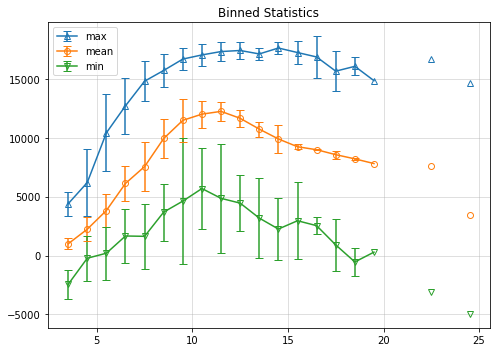

In [9]:
# Specify center of each wind speed bin, and signal name for analysis
bin_centers = np.arange(3.5,25.5,step=1) 
signal_name = 'TB_ForeAft'          

# Specify inputs to be used in plotting
bin_mean = bin_means[signal_name]
bin_max = bin_maxs[signal_name]
bin_min = bin_mins[signal_name]
bin_mean_std = bin_means_std[signal_name]
bin_max_std = bin_maxs_std[signal_name]
bin_min_std = bin_mins_std[signal_name]

# Plot binned statistics
loads.graphics.plot_bin_statistics(bin_centers,bin_mean,bin_max,bin_min,
                          bin_mean_std,bin_max_std,bin_min_std,
                          xlabel='Wind Speed [m/s]',
                          ylabel=signal_name,
                          title='Binned Statistics')
